In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm
from scipy.interpolate import CubicSpline
from scipy.spatial import Delaunay
from itertools import chain, product
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
import yaml

In [2]:
""" FSG rulebook/handbook specifications """
"""
    D8.1 Trackdrive Tracklayout
        • Constant Turns: up to 50 m diameter
        • Hairpin Turns: Minimum of 9 m outside diameter (of the turn)
        • Miscellaneous: Chicanes, multiple turns, decreasing radius turns, etc.
        • The minimum track width is 3 m
        • Distance between cones is maximally 5 m
    D8.1.2 The length of one lap is approximately 200 m to 500 m.
"""
parameters = yaml.safe_load(open("parameters.yaml"))

0.6987241679510136 3.0626558287170504
1.1617590510403062 3.342343319777851


(-3.061295873230873, 91.5012035044996, -4.594129666136842, 38.65127635372465)

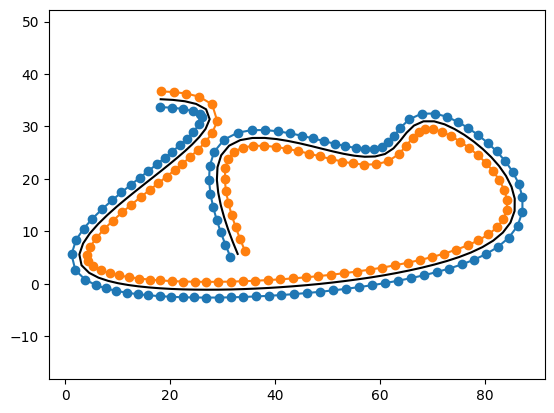

In [3]:
def generate_trajectory(c = 0.1, p: dict = {}) -> (np.ndarray, np.ndarray, np.ndarray):
    """
        Generate a trajectory which is a path through a Delaunay triangulation
        Respects global parameter `max_cone_dist`
        Also respects maximum curvature of the path
    """
    max_cone_dist = p["max_cone_dist"]
    min_cone_dist = p["min_cone_dist"]
    max_dist = p["max_dist"]
    fov_deg = p["fov_deg"]
    fov_rad = fov_deg * np.pi / 180

    # Generate data
    N = 20
    x = np.random.uniform(0, 1, size=(N,2))

    # Filter points that are close to each other
    k = True
    I = np.arange(N)
    while k:
        k = False
        for i, j in enumerate(I):
            y = np.linalg.norm(x[j] - x[I], axis=1)
            y[i] = np.inf
            m = y < c

            if np.any(m):
                k = True
                I = I[~m]
                break
    x = x[I]

    # Create Delaunay triangulation
    simplices = Delaunay(x).simplices

    I = [ 0 ]
    S = set(I)
    T = { i: [] for i in range(N) }
    for i, j, k in simplices:
        T[i] += [ (i, j, k) ]
        T[j] += [ (i, j, k) ]
        T[k] += [ (i, j, k) ]

    # Find a path through the triangulation
    for _ in range(2 * int(np.sqrt(N))):
        i = I[-1]
        K = list(filter(lambda k: k not in S, chain(*T[i])))
        if not K:
            break
        K = sorted(K, key=lambda k: -np.linalg.norm(x[k] - x[i]))
        k = K[-1]
        I += [ k ]
        S |= { k }
    x = x[I]

    # Smoothen the path
    X = CubicSpline(np.arange(len(x)), x, axis=0)

    t = np.linspace(0, len(x) - 1, 200)
    x = X(t)

    while True:
        n = np.roll(x, 1, axis=0) - x
        n[0] = n[1]
        s = np.cumsum(np.linalg.norm(n, axis=1))
        dn = np.roll(n, 1, axis=0) - n
        dn[0] = dn[1]
        k = np.abs(dn[:, 0] * n[:, 1] - dn[:, 1] * n[:, 0]) / (n[:, 0]**2 + n[:, 1]**2)**(3/2)
        k_max = np.max(k)
        s_max = s[-1]

        if (s_max < 90) or (1.5 / min_cone_dist < k_max):
            x *= 1.1
        else:
            n = np.roll(x, 1, axis=0) - x
            n[0] = n[1]
            s = np.cumsum(np.linalg.norm(n, axis=1))
            dn = np.roll(n, 1, axis=0) - n
            dn[0] = dn[1]
            k = np.abs(dn[:, 0] * n[:, 1] - dn[:, 1] * n[:, 0]) / (n[:, 0]**2 + n[:, 1]**2)**(3/2)
            break

    return x, s, k

def generate_cones(p: dict = {}) -> (np.ndarray, np.ndarray, np.ndarray):
    """
        Generate a set of cones which are placed along a trajectory
        Respects global parameters `max_cone_dist` and `min_cone_dist`
    """
    max_cone_dist = p["max_cone_dist"]
    min_cone_dist = p["min_cone_dist"]
    fov_deg = p["fov_deg"]

    # Find a trajectory which isn't too long, with not too step turns
    while True:
        x, s, k = generate_trajectory(p=p)
        if s[-1] < 300:
            break
    n = np.roll(x, 1, axis=0) - x; n[0] = n[1]; n /= np.linalg.norm(n, axis=1, keepdims=True)
    yaw = np.arctan2(n[:,1], n[:,0])

    # Find an interpolation which respects the maximum distance between cones
    S = np.cumsum(max_cone_dist * 1 / (min_cone_dist * k + 2))
    S = S[S < s[-1]]

    # Create dataset
    x = np.vstack((
        np.interp(S, s, x[:,0]),
        np.interp(S, s, x[:,1]),
        np.interp(S, s, yaw),
    )).T
    n = np.vstack((
        np.interp(S, s, n[:,0]),
        np.interp(S, s, n[:,1]),
    )).T
    v = np.vstack((n[:,1], -n[:,0])).T
    l = x[:,:2] + min_cone_dist * v / 2
    r = x[:,:2] - min_cone_dist * v / 2

    return x, l, r

x, l, r = generate_cones(p = parameters)
dl = np.linalg.norm(np.diff(l, axis=0), axis=1)
dr = np.linalg.norm(np.diff(r, axis=0), axis=1)
print(np.min(dl), np.max(dl))
print(np.min(dr), np.max(dr))
plt.plot(x[:,0], x[:,1], 'k-')
plt.plot(l[:,0], l[:,1], 'o-')
plt.plot(r[:,0], r[:,1], 'o-')
plt.axis('equal')

(-3.3621464097886546,
 97.81906477221303,
 -27.873260450188056,
 39.759806391060415)

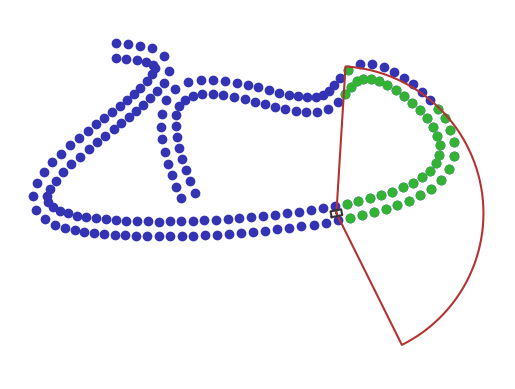

In [4]:
i = len(x) // 2
cones = homogenize(np.vstack((l, r)))
pose = x[i].copy()
visible_cones = get_visible_cones(cones, pose, p=parameters)

plot_cones(cones)
plot_cones(visible_cones, color=(0.2,0.7,0.2))
plot_fov(pose, p=parameters)
plot_car(pose, p=parameters)
plt.axis('equal')
plt.axis('off')

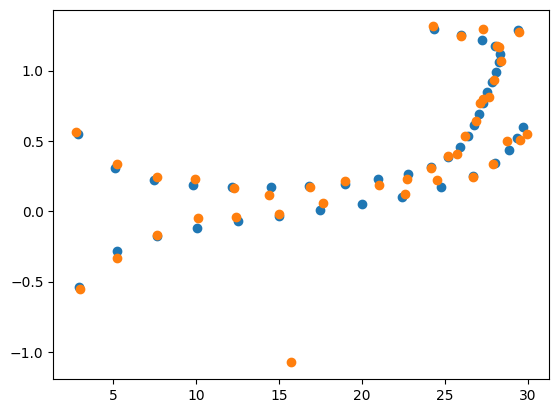

In [5]:
_n = 1
def get_measurement(cones: np.ndarray((_n, 3)), pose: np.ndarray((3,)), p: dict = {}) -> np.ndarray((_n, 3)):
    visible_cones = get_visible_cones(cones, pose, p=p)
    return to_m_frame(visible_cones, pose)

def disturb_measurement(measurement: np.ndarray((_n, 3)), p: dict = {}) -> np.ndarray((_n, 3)):
    max_dist = p["max_dist"]
    fov_rad = p["fov_deg"] * np.pi / 180
    false_negative_rate = p["false_negative_rate"]
    false_positive_rate = p["false_positive_rate"]
    measurement_noise_fov_deg = p["measurement_noise_fov_deg"]
    measurement_noise_dist = p["measurement_noise_dist"]

    n_fov_rad = measurement_noise_fov_deg * np.pi / 180
    n_dist = measurement_noise_dist

    n = measurement.shape[0]
    measurement += np.random.normal(0, 1, size=(n, 3)) @ np.diag([n_dist, n_fov_rad, 0])

    noisy_measurement = []
    for (angle, distance, likelihood) in measurement:
        if np.random.uniform() < false_negative_rate:
            continue
        if np.random.uniform() < false_positive_rate:
            noisy_measurement += [ (np.random.uniform(0, max_dist), np.random.uniform(-fov_rad/2, fov_rad/2), np.random.uniform(0, 0.4)) ]
        else:
            noisy_measurement += [ (angle, distance, np.random.uniform(0.6, 0.95)) ]
    
    return np.array(noisy_measurement)

measurement = get_measurement(cones, pose, p=parameters)
plt.plot(measurement[:,0], measurement[:,1], 'o')

measurement = disturb_measurement(measurement, p=parameters)
plt.plot(measurement[:,0], measurement[:,1], 'o')

In [6]:
_n, _m = 1, 1
def find_pflow_g(y: np.ndarray((_n,3)), x: np.ndarray((_m, 3)), pose:np.ndarray((3,)), p: dict = {}):
    threshold = p["min_cone_dist"]
    y = y.copy()[:, :2]
    D = np.linalg.norm(y[:,:2].reshape((-1, 1, 2)) - x[:,:2].reshape((1, -1, 2)), axis=2)
    a = np.argmin(D, axis=1)
    y[:,0] = np.fmod(x[a,2] + np.pi, 2*np.pi) - np.pi
    y[:,1] = np.min(D, axis=1) < threshold
    return y

def find_pflow_m(y: np.ndarray((_n,3)), x: np.ndarray((_m, 3)), pose:np.ndarray((3,)), p: dict = {}):
    threshold = p["min_cone_dist"]
    y = y.copy()[:, :2]
    D = np.linalg.norm(y[:,:2].reshape((-1, 1, 2)) - x[:,:2].reshape((1, -1, 2)), axis=2)
    a = np.argmin(D, axis=1)
    y[:,0] = np.fmod(x[a,2] - pose[2] + np.pi, 2 * np.pi) - np.pi
    y[:,1] = np.min(D, axis=1) < threshold
    return y

(31, 3)


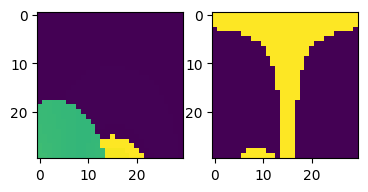

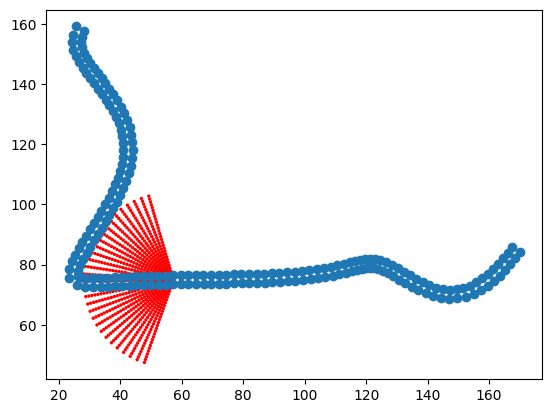

In [7]:
def discretize_m(p: dict = {}) -> np.ndarray:
    W, H = p["W"], p["H"]
    max_dist = p["max_dist"]
    fov_deg = p["fov_deg"]
    fov_rad = fov_deg * np.pi / 180

    # Create discretization
    w_min = 0
    w_max = max_dist
    w = np.arange(W) * (w_max - w_min) / W
    h_min = -fov_rad / 2
    h_max = fov_rad / 2
    h = np.arange(H) * (h_max - h_min) / H
    pflow = np.zeros((W, H, 2))

    def discretize(x: np.ndarray, y: np.ndarray):
        i = ((x - w_min) / (w_max - w_min) * W).astype(np.int32)
        j = ((y - h_min) / (h_max - h_min) * H).astype(np.int32)
        i = np.clip(i, 0, W - 1)
        j = np.clip(j, 0, H - 1)
        return i, j
    
    def undiscretize(i: np.ndarray, j: np.ndarray):
        x = i.astype(np.float32) / W * (w_max - w_min) + w_min
        y = j.astype(np.float32) / H * (h_max - h_min) + h_min
        return x, y
    
    return pflow.copy(), discretize, undiscretize

x, l, r = generate_cones(p = parameters)
pflow, discretize, undiscretize = discretize_m(p=parameters)

i = len(x) // 2
cones = homogenize(np.vstack((l, r)))
pose = x[i].copy()
measurement = get_measurement(cones, pose, p=parameters)
measurement = disturb_measurement(measurement, p=parameters)
print(measurement.shape)

# illusion
W, H = pflow.shape[:2]
w, h = np.arange(W), np.arange(H)
X, Y = undiscretize(w, h)
V = np.array([ (X[i], Y[j], 1) for i in w for j in h ])
V = to_g_frame(V, pose)
pflows = find_pflow_g(V, x, pose, p=parameters)
V = V.reshape((W, H, 3))
pflows = pflows.reshape((W, H, 2))

ax1, ax2 = plt.subplot(1,3,1), plt.subplot(1,3,2)
ax1.imshow(pflows[:, :, 0])
ax2.imshow(pflows[:, :, 1])
plt.show()
for i in range(W):
    for j in range(H):
        plt.quiver(V[i, j, 0], V[i, j, 1], np.cos(pflows[i, j, 0]) * pflows[i, j, 1], np.sin(pflows[i, j, 0]) * pflows[i, j, 1], scale=0.5, scale_units='xy', angles='xy', color='r')
plt.plot(cones[:,0], cones[:,1], 'o')

100%|██████████| 1000/1000 [06:19<00:00,  2.64it/s]


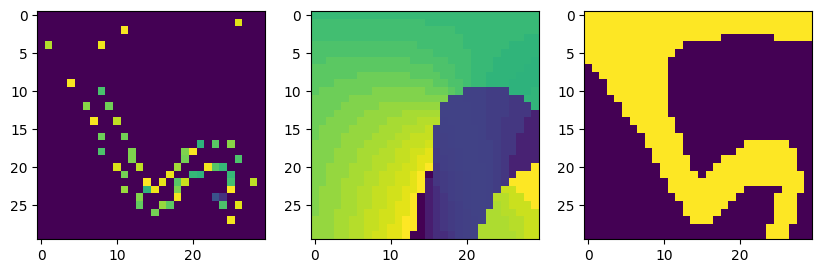

In [8]:
N, M = parameters['N'], parameters['M']
K = N*M
W, H = parameters['W'], parameters['H']

measurements = np.zeros((K, W, H))
solutions = np.zeros((K, 2, W, H))

for n in tqdm(range(N)):
    pflow, discretize, undiscretize = discretize_m(p=parameters)
    
    x, l, r = generate_cones(p = parameters)
    i = len(x) // 2
    cones = homogenize(np.vstack((l, r)))

    for m in range(M):
        pose = x[i].copy()
        pose[0] += np.random.uniform(-1, 1)
        pose[1] += np.random.uniform(-1, 1)
        pose[2] += np.random.uniform(-np.pi/3, np.pi/3)

        # get flow
        w, h = np.arange(W), np.arange(H)
        X, Y = undiscretize(w, h)
        V = np.array([ (X[i], Y[j], 1) for i in w for j in h ])
        V = to_g_frame(V, pose)
        pflows = find_pflow_m(V, x, pose, p=parameters)
        pflows = pflows.reshape((W, H, 2))

        # get measurement
        measurement = get_measurement(cones, pose, p=parameters)
        measurement = disturb_measurement(measurement, p=parameters)
        z = np.zeros((W, H))
        for i, j, p in measurement:
            i, j = discretize(i, j)
            z[i, j] = p

        # save
        measurements[n*M + m] = z
        solutions[n*M + m, 0, :, :] = pflows[:, :, 0]
        solutions[n*M + m, 1, :, :] = pflows[:, :, 1]

axs = plt.subplots(1, 3, figsize=(10, 10))[1]
axs[0].imshow(measurements[0])
axs[1].imshow(solutions[0, 0, :, :])
axs[2].imshow(solutions[0, 1, :, :])

In [54]:
class Reconstructor(nn.Module):
    def __init__(self, p: dict = {}):
        super(Reconstructor, self).__init__()
        self.fc = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 1, 3, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.fc(x)


reconstructor = Reconstructor()
optimizer = optim.Adam(reconstructor.parameters(), lr=1e-3)
criterion = nn.BCELoss()

running_loss = 0
for epoch, k in enumerate(np.random.permutation(1000)):
    z = measurements[k].reshape((1, 1, W, H))
    p = solutions[k, 1, :, :].reshape((1, 1, W, H))
    z = torch.from_numpy(z).float()
    p = torch.from_numpy(p).float()
    y = reconstructor(z)
    loss = criterion(y, p)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss = loss.item() * 0.1 + 0.9 * running_loss
    if epoch % int(np.sqrt(K)) == 0:
        print(f'loss: {running_loss:.4f}, k: {epoch}/{K}')

loss: 0.0691, k: 0/100000
loss: 0.2452, k: 316/100000
loss: 0.2016, k: 632/100000
loss: 0.2083, k: 948/100000


In [80]:
class Flower(nn.Module):
    def __init__(self, p: dict = {}):
        super(Flower, self).__init__()
        self.fc = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 4, 3, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.fc(x)

flower = Flower()
optimizer = optim.Adam(flower.parameters(), lr=1e-3)
criterion = nn.BCELoss()

running_loss = 0
for epoch, k in enumerate(np.random.permutation(4000)):
    z = solutions[k, 1, :, :].reshape((1, 1, W, H))
    p = solutions[k, 0, :, :]
    P = np.zeros((1, 4, W, H))
    P[0, 0] = np.abs(np.cos(p))**2
    P[0, 1] = np.abs(np.sin(p))**2
    P[0, 2] = np.abs(-np.cos(p))**2
    P[0, 3] = np.abs(-np.sin(p))**2
    z = torch.from_numpy(z).float()
    p = torch.from_numpy(P).float()
    y = flower(z)
    loss = criterion(y, p)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss = loss.item() * 0.1 + running_loss * 0.9
    if epoch % int(np.sqrt(K)) == 0:
        print(f'loss: {running_loss:.4f}, k: {epoch}/{K}')

loss: 0.0689, k: 0/100000
loss: 0.6311, k: 316/100000
loss: 0.6865, k: 632/100000
loss: 0.6200, k: 948/100000
loss: 0.6408, k: 1264/100000
loss: 0.6665, k: 1580/100000
loss: 0.6568, k: 1896/100000
loss: 0.6709, k: 2212/100000
loss: 0.6105, k: 2528/100000
loss: 0.6894, k: 2844/100000
loss: 0.6574, k: 3160/100000
loss: 0.6517, k: 3476/100000
loss: 0.6517, k: 3792/100000


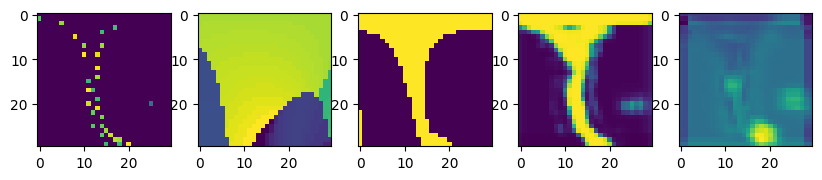

In [107]:
pflow, discretize, undiscretize = discretize_m(p=parameters)

x, l, r = generate_cones(p = parameters)
i = len(x) // 2
cones = homogenize(np.vstack((l, r)))

pose = x[i].copy()
pose[0] += np.random.uniform(-1, 1)
pose[1] += np.random.uniform(-1, 1)
pose[2] += np.random.uniform(-np.pi/3, np.pi/3)

# get flow
w, h = np.arange(W), np.arange(H)
X, Y = undiscretize(w, h)
V = np.array([ (X[i], Y[j], 1) for i in w for j in h ])
V = to_g_frame(V, pose)
pflows = find_pflow_m(V, x, pose, p=parameters)
pflows = pflows.reshape((W, H, 2))

# get measurement
measurement = get_measurement(cones, pose, p=parameters)
measurement = disturb_measurement(measurement, p=parameters)
z = np.zeros((W, H))
for i, j, p in measurement:
    i, j = discretize(i, j)
    z[i, j] = p

z = z.reshape((1, 1, W, H))
reconstruction = reconstructor(torch.from_numpy(z).float()).detach().numpy()
flow = flower(torch.from_numpy(reconstruction).float()).detach().numpy()
_cos = flow[0,0]
_sin = flow[0,1]
_yaw = np.arctan2(_sin, _cos)

axs = plt.subplots(1, 5, figsize=(10, 10))[1]
axs[0].imshow(z.reshape((W,H)))
axs[1].imshow(pflows[:, :, 0])
axs[2].imshow(pflows[:, :, 1])
axs[3].imshow(reconstruction.reshape((W,H)))
axs[4].imshow(_yaw)